<a href="https://colab.research.google.com/github/gongx030/etv2_pioneer/blob/master/early_late_sustained_Etv2_peaks_in_MEF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Compare Etv2 ChIP-seq between D1 and D7 during MEF reprogramming
by Wuming Gong



A large proportion of running time is used by `normalizeToMatrix` from `EnrichedHeatmap` package to prepare the matrices for generating heatmap.  `normalizeToMatrix` is particularly slow when there are many (e.g. > 10,000) genomic intervals.

In [1]:
start_time0 <- Sys.time()

## Install R packages

In [2]:
if (!requireNamespace("BiocManager", quietly = TRUE))
  install.packages("BiocManager")
BiocManager::install(c(
  'GenomicRanges', 'rtracklayer', 'EnrichedHeatmap', 'BSgenome.Mmusculus.UCSC.mm10',
  'circlize', 'ChIPseeker', 'TxDb.Mmusculus.UCSC.mm10.knownGene', 'org.Mm.eg.db',
  'GO.db'
), Ncpus = 2)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Bioconductor version 3.11 (BiocManager 1.30.10), R 4.0.2 (2020-06-22)

Installing package(s) 'BiocVersion', 'GenomicRanges', 'rtracklayer',
  'EnrichedHeatmap', 'BSgenome.Mmusculus.UCSC.mm10', 'circlize', 'ChIPseeker',
  'TxDb.Mmusculus.UCSC.mm10.knownGene', 'org.Mm.eg.db', 'GO.db'

also installing the dependencies ‘formatR’, ‘lambda.r’, ‘futile.options’, ‘bit’, ‘data.table’, ‘fastmatch’, ‘triebeard’, ‘tweenr’, ‘polyclip’, ‘RcppEigen’, ‘RcppArmadillo’, ‘futile.logger’, ‘snow’, ‘DelayedArray’, ‘bit64’, ‘plogr’, ‘DO.db’, ‘fgsea’, ‘qvalue’, ‘urltools’, ‘gridGraphics’, ‘rvcheck’, ‘ggforce’, ‘ggrepel’, ‘viridis’, ‘tidygraph’, ‘graphlayouts’, ‘BiocFileCache’, ‘rappdirs’, ‘GenomeInfoDbData’, ‘bitops’, ‘BiocParallel’, ‘Rhtslib’, ‘SummarizedExperiment’, ‘clue’, ‘png’, ‘rjson’, ‘Biobase’, ‘RSQLite’, ‘cowplot’, ‘DOSE’, ‘europepmc’, ‘ggplotify’, ‘ggraph’, ‘ggridges’, ‘GOSemSim’, ‘gridExtra’, ‘igraph’, ‘plyr’, ‘resha

In [3]:
library(GenomicRanges)
library(circlize)
library(dplyr)
library(BSgenome.Mmusculus.UCSC.mm10)
library(ChIPseeker)
library(TxDb.Mmusculus.UCSC.mm10.knownGene)
library(org.Mm.eg.db)
library(GO.db)
library(EnrichedHeatmap)
library(rtracklayer)

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which, which.max, which.min


Loading required package: S4Vectors


Attaching package: ‘S4Vectors’


The

## Read a combined Etv2 ChIP-seq peak set

In [4]:
all_etv2_peaks_url <- 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2PioneerChIPseq_version=20191203a/all_Etv2_peaks.rds'
gr <- readRDS(gzcon(url(all_etv2_peaks_url)))
gr
colnames(gr$group)

GRanges object with 162010 ranges and 4 metadata columns:
           seqnames            ranges strand |
              <Rle>         <IRanges>  <Rle> |
       [1]     chr1   3037784-3037983      * |
       [2]     chr1   3263790-3263989      * |
       [3]     chr1   3344682-3344881      * |
       [4]     chr1   3460640-3460839      * |
       [5]     chr1   3490314-3490513      * |
       ...      ...               ...    ... .
  [162006]     chrY 90828936-90829135      * |
  [162007]     chrY 90836259-90836458      * |
  [162008]     chrY 90841624-90841823      * |
  [162009]     chrY 90842563-90842762      * |
  [162010]     chrY 90843810-90844009      * |
                                                                                                                 peak_id
                                                                                                             <character>
       [1]      /panfs/roc/scratch/gongx030/datasets/dataset=Etv2PioneerChIPseq_version=2

[1] "MEF_Dox_d1_Etv2" "MEF_Dox_d2_Etv2" "MEF_Dox_d7_Etv2" "EB_Dox_3h_Etv2" 
[5] "EB_Dox_12h_Etv2"

## Download related `pileup` and `fold enrichment` bigwig files

`rtracklayer::import` does not support importing bigwig files with URL starting with 'https://'. We need to download the bigwig files first.

In [5]:
bw_files <- c(
	'MEF_Dox_D1_Etv2' 									= 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2PioneerChIPseq_version=20191203a/MEF_Dox_d1_Etv2_FE.bw',
	'MEF_Dox_D2_Etv2' 									= 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2PioneerChIPseq_version=20191203a/MEF_Dox_d2_Etv2_FE.bw',
	'MEF_Dox_D7_Etv2' 									= 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2PioneerChIPseq_version=20191203a/MEF_Dox_d7_Etv2_FE.bw',
	'MEF_NoDox_Brg1' 										= 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2PioneerChIPseq_version=20191203a/MEF_NoDox_d0_Brg1_FE.bw',
	'MEF_Dox_D1_Brg1' 									= 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2PioneerChIPseq_version=20191203a/MEF_Dox_d1_Brg1_FE.bw',
	'MEF_Dox_D2_Brg1' 									= 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2PioneerChIPseq_version=20191203a/MEF_Dox_d2_Brg1_FE.bw',
	'MEF_Dox_D7_Brg1' 									= 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2PioneerChIPseq_version=20191203a/MEF_Dox_d7_Brg1_FE.bw',
  'MEF_NoDox_H3K27ac' 								= 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2PioneerChIPseq_version=20191203a/MEF_NoDox_d0_H3K27ac_FE.bw',
  'MEF_Dox_D1_H3K27ac' 								= 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2PioneerChIPseq_version=20191203a/MEF_Dox_d1_H3K27ac_FE.bw',
  'MEF_Dox_D2_H3K27ac' 								= 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2PioneerChIPseq_version=20191203a/MEF_Dox_d2_H3K27ac_FE.bw',
  'MEF_Dox_D7_H3K27ac' 								= 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2PioneerChIPseq_version=20191203a/MEF_Dox_d7_H3K27ac_FE.bw'
#	'MNase'                             = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Chronis_version=20170519a/MNase_treat_pileup.bw',
#	'H3'                                = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Chronis_version=20170519a/H3_treat_pileup.bw',
#	'H3K9me3'                           = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Chronis_version=20170519a/H3K9me3_treat_pileup.bw',
#	'H3K27me3'                          = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Chronis_version=20170519a/H3K27me3_treat_pileup.bw',
#	'H3K36me3'                          = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Chronis_version=20170519a/H3K36me3_treat_pileup.bw',
#	'H3K9ac'                            = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Chronis_version=20170519a/H3K9ac_treat_pileup.bw',
#	'H3K79me2'                          = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Chronis_version=20170519a/H3K79me2_treat_pileup.bw',
#	'H3K4me2'                           = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Chronis_version=20170519a/H3K4me2_treat_pileup.bw',
#	'H3K4me1'                           = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Chronis_version=20170519a/H3K4me1_treat_pileup.bw',
#	'Hdac1'                             = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Chronis_version=20170519a/Hdac1_treat_pileup.bw',
#	'H3.3'                              = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Chronis_version=20170519a/H3.3_treat_pileup.bw',
#	'P300'                              = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Chronis_version=20170519a/P300_treat_pileup.bw',
#	'EB_Dox_3h_Etv2' 					= 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2PioneerChIPseq_version=20191203a/EB_Dox_3h_Etv2_FE.bw',
#	'EB_Dox_12h_Etv2' 					= 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2PioneerChIPseq_version=20191203a/EB_Dox_12h_Etv2_FE.bw',
#	'EB_Dox_3h_Brg1' =  'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2PioneerChIPseq_version=20191203a/EB_Dox_3h_Brg1_FE.bw',
#	'EB_Dox_12h_Brg1' = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2PioneerChIPseq_version=20191203a/EB_Dox_12h_Brg1_FE.bw',
#	'EB_NoDox_3h_Brg1' = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2PioneerChIPseq_version=20191203a/EB_NoDox_3h_Brg1_FE.bw',
#	'EB_NoDox_12h_Brg1' = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2PioneerChIPseq_version=20191203a/EB_NoDox_12h_Brg1_FE.bw',
#	'EB_Dox_3h_H3K27ac' = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2PioneerChIPseq_version=20191203a/EB_Dox_3h_H3K27ac_FE.bw',
#	'EB_Dox_12h_H3K27ac' = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2PioneerChIPseq_version=20191203a/EB_Dox_12h_H3K27ac_FE.bw',
#	'EB_NoDox_3h_H3K27ac' = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2PioneerChIPseq_version=20191203a/EB_NoDox_3h_H3K27ac_FE.bw',
#	'EB_NoDox_12h_H3K27ac' = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2PioneerChIPseq_version=20191203a/EB_NoDox_12h_H3K27ac_FE.bw'
)

In [6]:
local_bw_files <- gsub('https://s3.msi.umn.edu/', './', bw_files)
commands <- sprintf('wget -x -c -nH %s', bw_files)
lapply(commands, function(command) system(command))
file.exists(local_bw_files)

[[1]]
[1] 0

[[2]]
[1] 0

[[3]]
[1] 0

[[4]]
[1] 0

[[5]]
[1] 0

[[6]]
[1] 0

[[7]]
[1] 0

[[8]]
[1] 0

[[9]]
[1] 0

[[10]]
[1] 0

[[11]]
[1] 0

[1] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE

## A Heatmap Etv2/Brg1/H3K27ac ChIP-seq signals over early/late/sustained Etv2 peaks in MEF


### Split the Etv2 MEF D1 peaks into three groups
1. on at D1 and off at D7 (early)
2. off at D1 and on at D7 (late)
3. on at both D1 and D7 (sustained)

In [7]:
peaks <- gr[gr$group[, 'MEF_Dox_d1_Etv2'] | gr$group[, 'MEF_Dox_d7_Etv2']]
cat(sprintf('number of early peaks: %d\n', sum(peaks$group[, 'MEF_Dox_d1_Etv2'] & !peaks$group[, 'MEF_Dox_d7_Etv2'])))
cat(sprintf('number of late peaks: %d\n', sum(!peaks$group[, 'MEF_Dox_d1_Etv2'] & peaks$group[, 'MEF_Dox_d7_Etv2'])))
cat(sprintf('number of sustained peaks: %d\n', sum(peaks$group[, 'MEF_Dox_d1_Etv2'] & peaks$group[, 'MEF_Dox_d7_Etv2'])))

number of early peaks: 111167
number of late peaks: 4222
number of sustained peaks: 12170


### Prepare normalized matrix for `EnrichedHeatmap`

In [8]:
extend <- 1000
w <- 50
smooth <- FALSE
target_ratio <- 0.2
mc.cores <- 2
target_width <- width(peaks)[1]
cat(sprintf('# peaks: %d\n', length(peaks)))
cat(sprintf('target width: %d\n', target_width))

# peaks: 127559
target width: 200


In [9]:
get_normalizeToMatrix <- function(bw_file, peaks, extend, w, smooth = FALSE, target_ratio = 0.2, ...){
  cvg <- rtracklayer::import(bw_file, which = trim(GenomicRanges::reduce(resize(peaks, fix = 'center', width = target_width + extend * 2))))  # returned as a GRanges object
  mat <- normalizeToMatrix(cvg, peaks, extend = extend, value_column = 'score', mean_mode = 'w0', w = w, smooth = smooth, target_ratio = target_ratio, ...)
  mat
} # get_normalizeToMatrix

In [10]:
mat <- mclapply(local_bw_files, function(bw_file){
  cvg <- rtracklayer::import(
    bw_file, 
    which = trim(GenomicRanges::reduce(resize(peaks, fix = 'center', width = target_width + extend * 2)))
  )  # returned as a GRanges object
  normalizeToMatrix(
    cvg, 
    peaks, 
    extend = extend, 
    value_column = 'score', 
    mean_mode = 'w0', 
    w = w, 
    smooth = smooth, 
    target_ratio = target_ratio
  )
}, mc.cores = 2)

### Color scheme of the heatmap

In [11]:
group_cols <- rep('blue', length(bw_files))
names(group_cols) <- names(bw_files)
group_cols[c('H3', 'MNase')] <- 'green'
group_cols[c('MEF_Dox_D1_Etv2', 'MEF_Dox_D2_Etv2', 'MEF_Dox_D7_Etv2')] <- 'red'
group_cols[c('MEF_NoDox_Brg1', 'MEF_Dox_D1_Brg1', 'MEF_Dox_D2_Brg1', 'MEF_Dox_D7_Brg1')] <- 'purple'
group_cols[c('MEF_NoDox_H3K27ac', 'MEF_Dox_D1_H3K27ac', 'MEF_Dox_D2_H3K27ac', 'MEF_Dox_D7_H3K27ac')] <- 'darkgreen'
col_fun <- lapply(1:length(mat), function(i) colorRamp2(quantile(mat[[i]], c(0.005, 0.995)), c('white', group_cols[i])))
names(col_fun) <- names(bw_files)

### Generate the heatmap

`use_raster` is automatically set to TRUE for a matrix with more than
2000 rows. You can control `use_raster` arugment by explicitly setting
TRUE/FALSE to it. Set `ht_opt$message = FALSE` to turn off this
message.

`use_raster` is automatically set to TRUE for a matrix with more than
2000 rows. You can control `use_raster` arugment by explicitly setting
TRUE/FALSE to it. Set `ht_opt$message = FALSE` to turn off this
message.

`use_raster` is automatically set to TRUE for a matrix with more than
2000 rows. You can control `use_raster` arugment by explicitly setting
TRUE/FALSE to it. Set `ht_opt$message = FALSE` to turn off this
message.

`use_raster` is automatically set to TRUE for a matrix with more than
2000 rows. You can control `use_raster` arugment by explicitly setting
TRUE/FALSE to it. Set `ht_opt$message = FALSE` to turn off this
message.

`use_raster` is automatically set to TRUE for a matrix with more than
2000 rows. You can control `use_raster` arugment by explicitly setting

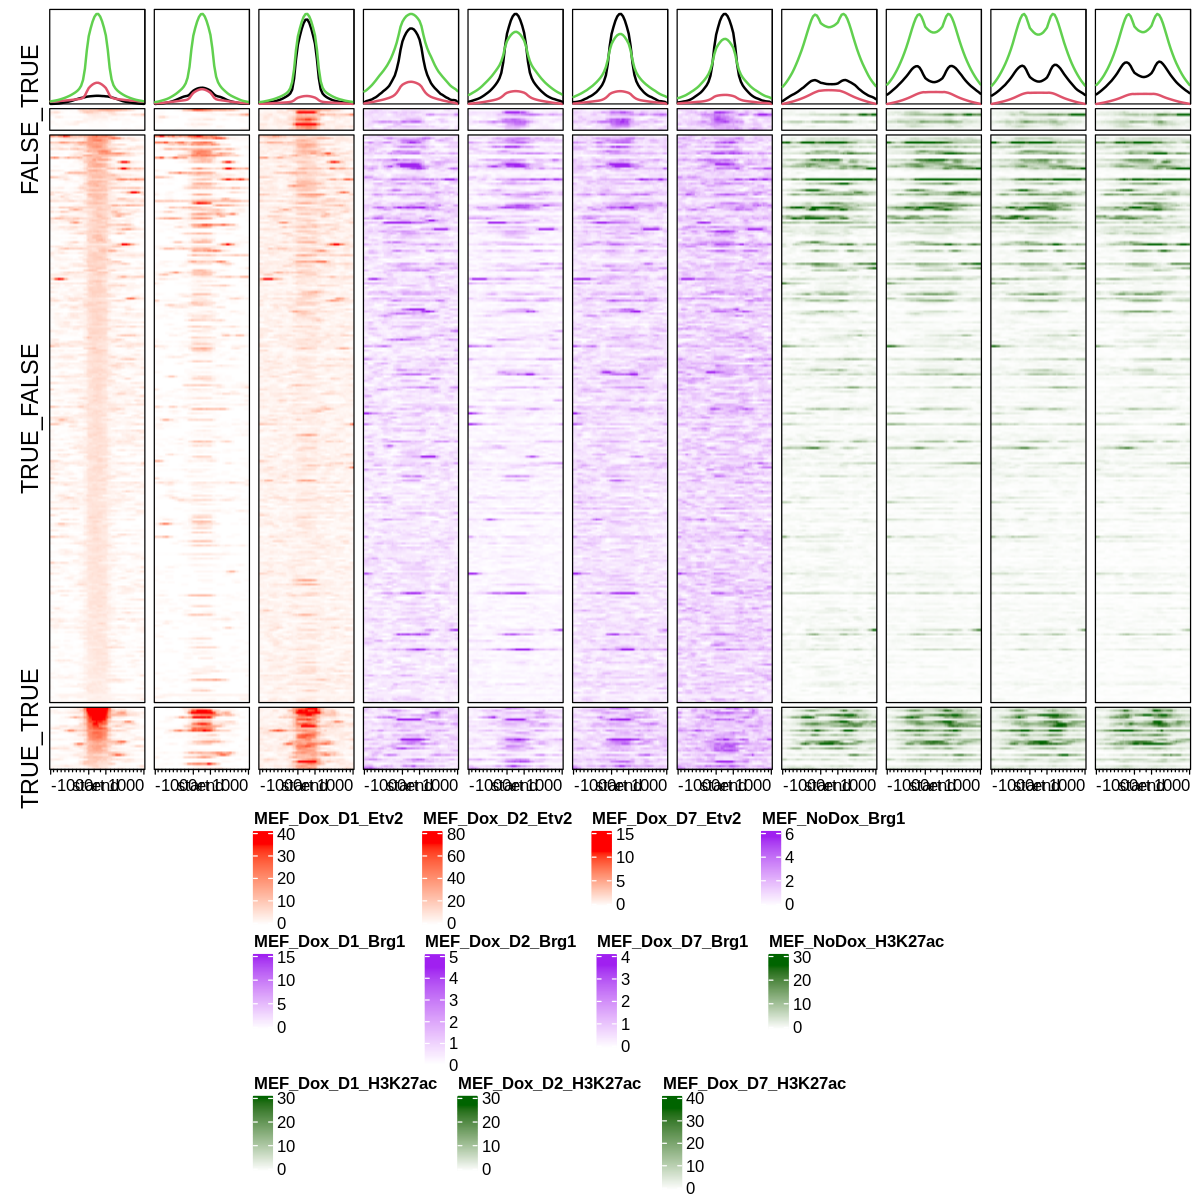

In [12]:
i <- 1:length(peaks)
sp <- factor(sprintf('%s_%s', peaks$group[, 'MEF_Dox_d1_Etv2'], peaks$group[, 'MEF_Dox_d7_Etv2']))
ta <- HeatmapAnnotation(
  enriched = anno_enriched(gp = gpar(lty = 1, lwd = 2, col = 1:nlevels(sp)), 
  axis_param = list(facing = 'inside', at = -1000))
)
h <- EnrichedHeatmap(
  mat[['MEF_Dox_D1_Etv2']][i, ], 
  col = col_fun[['MEF_Dox_D1_Etv2']], 
  split = sp[i], 
  name = 'MEF_Dox_D1_Etv2', 
  top_annotation = ta, 
  pos_line = FALSE
)
ss <- c(
  'MEF_Dox_D2_Etv2', 'MEF_Dox_D7_Etv2', 
  'MEF_NoDox_Brg1', 'MEF_Dox_D1_Brg1', 'MEF_Dox_D2_Brg1', 'MEF_Dox_D7_Brg1', 
  'MEF_NoDox_H3K27ac', 'MEF_Dox_D1_H3K27ac', 'MEF_Dox_D2_H3K27ac', 'MEF_Dox_D7_H3K27ac'
)
for (s in ss[ss %in% names(bw_files)]){
  h <- h + EnrichedHeatmap(mat[[s]][i, ], col = col_fun[[s]], name = s, top_annotation = ta, pos_line = FALSE)
}
options(repr.plot.width = 10, repr.plot.height = 10)
draw(h, heatmap_legend_side = 'bottom')

In [13]:
sessionInfo()

R version 4.0.2 (2020-06-22)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 18.04.5 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/openblas/libblas.so.3
LAPACK: /usr/lib/x86_64-linux-gnu/libopenblasp-r0.2.20.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
 [1] grid      parallel  stats4    stats     graphics  grDevices utils    
 [8] datasets  methods   base     

other attached packages:
 [1] EnrichedHeatmap_1.18.2                   
 [2] ComplexHeatmap_2.4.3                     
 [3] GO.db_3.11.4                             
 [4] org.Mm.eg.db_3.11.4                      
 [5] TxDb.Mmusculus.UCSC.mm10.knownGene_3.10.0

In [14]:
Sys.time() - start_time0

Time difference of 1.516958 hours